In [1]:
import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cell line data
metabolite_data  = pd.read_csv("../Data/Cancer_CellLine_Encylopedia/CCLE_metabolomics.csv")
# Load pre-labelled mutations from CCLE
FH_mutations  = pd.read_csv("../Data/Cancer_CellLine_Encylopedia/FH_mutant_celllines.csv")

In [3]:
metabolite = "fumarate/maleate/alpha-ketoisovalerate"

# Sort the data by metabolite of interest
metabolite_data = metabolite_data.sort_values(by = metabolite, ascending=True)
metabolite_data = metabolite_data.reset_index()
metabolite_data["index"] = metabolite_data.index

# Merge the mutations and metabolomics
metabolomics_mutation_combined = metabolite_data.merge(FH_mutations, right_on = "Tumor_Sample_Barcode", left_on = "CCLE_ID", how = "outer")
# Drop NA and bad values
metabolomics_mutation_combined = metabolomics_mutation_combined[np.isfinite(metabolomics_mutation_combined[metabolite])]
metabolomics_mutation_combined_mutationonly = metabolomics_mutation_combined[metabolomics_mutation_combined["Variant_Classification"].notna()]

# Seperate out our predicted mutational effects
metabolomics_mutation_combined_mutationonly_known = metabolomics_mutation_combined_mutationonly[metabolomics_mutation_combined_mutationonly["Effect"].isin(["p_Del", "p_Silent"])]


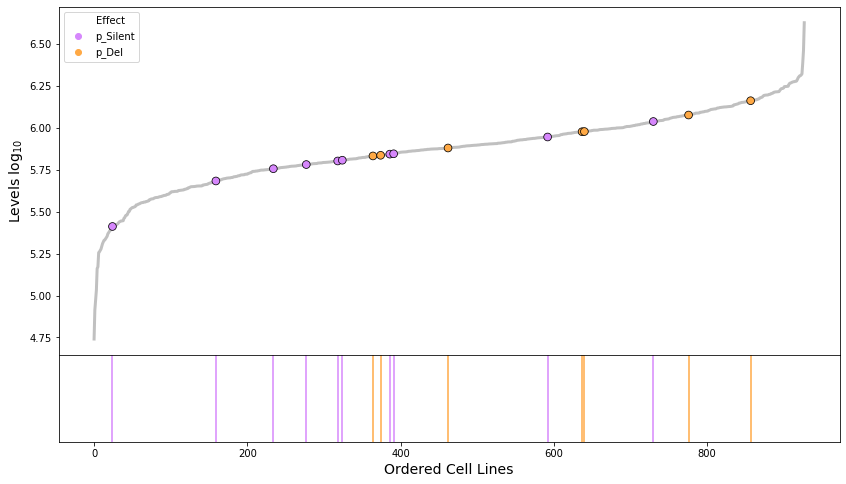

In [4]:
matplotlib.rcParams['figure.figsize'] = [14, 8]

f, (ax_top, ax_bottom) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.8, .20)})
f.subplots_adjust(hspace = 0)


# Set up palette and order
palette2 = ["#D687FC", "#FFA945"]
order2 = ["p_Silent", "p_Del"]



#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Plot all mutations and our predicted mutations
sns.lineplot(metabolite_data["index"], metabolite_data[metabolite], zorder = 1, lw = 3, color = "#C0C0C0", ax = ax_top)
sns.scatterplot(metabolomics_mutation_combined_mutationonly_known["index"], metabolomics_mutation_combined_mutationonly_known[metabolite], hue=metabolomics_mutation_combined_mutationonly_known["Effect"], zorder =2, s = 60, palette = palette2, ax = ax_top, edgecolor = "k", hue_order = order2)

# Get the rows from the dataframe for plotting on the lineplot below
deletion = metabolomics_mutation_combined_mutationonly[metabolomics_mutation_combined_mutationonly["Effect"] == "p_Del"]
silent = metabolomics_mutation_combined_mutationonly[metabolomics_mutation_combined_mutationonly["Effect"] == "p_Silent"]

# Add lines
for row,values in deletion.iterrows():
    ranking =(values["index"])
    ax_bottom.axvline(ranking, c = "#FFA945")
          
for row,values in silent.iterrows():
    ranking =(values["index"])
    ax_bottom.axvline(ranking, c = "#D687FC")
    
ax_bottom.set_yticks([])

ax_bottom.set_xlabel("Ordered Cell Lines", size = 14)
ax_top.set_ylabel("Levels log$_{10}$", size = 14)

plt.savefig("Figure_6_B_CCLE_fumaratecorrelation.pdf")

In [5]:
# Calculate p value
import scipy.stats as stats
FH_levels_del = deletion["fumarate/maleate/alpha-ketoisovalerate"]
FH_levels_silent = silent["fumarate/maleate/alpha-ketoisovalerate"]

stats.ttest_ind(a = FH_levels_del, b = FH_levels_silent)

Ttest_indResult(statistic=2.3137065716429905, pvalue=0.03527649544970538)

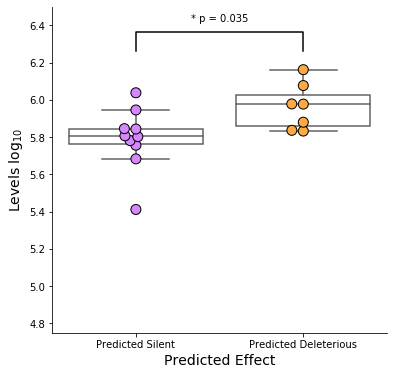

In [6]:
# Generate swarmplot
matplotlib.rcParams['figure.figsize'] = [6, 6]
palette = ["#D687FC", "#FFA945"]
ax = sns.boxplot(x = metabolomics_mutation_combined_mutationonly_known["Effect"], y=  metabolomics_mutation_combined_mutationonly_known["fumarate/maleate/alpha-ketoisovalerate"], palette = palette, boxprops={'facecolor':'None'})
ax = sns.swarmplot(x = metabolomics_mutation_combined_mutationonly_known["Effect"], y=  metabolomics_mutation_combined_mutationonly_known["fumarate/maleate/alpha-ketoisovalerate"], palette = palette, s = 10, linewidth = 1, edgecolor = "black")


sns.despine()
ax.set_ylim([4.75, 6.50])
ax.set_xlabel("Predicted Effect", size = 14)
ax.set_ylabel("Levels log$_{10} $", size = 14)
ax.set_xticklabels(["Predicted Silent", "Predicted Deleterious"])

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = metabolomics_mutation_combined_mutationonly_known['fumarate/maleate/alpha-ketoisovalerate'].max() + 0.1, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+0.15, "* p = 0.035", ha='center', va='bottom', color=col)
plt.savefig("Figure_6_C_CCLE_swarmplotfumaratecorrelation.pdf")